# Lineær regression - Kan vi estimere antallet af linjer

- **Problem:** Kan jeg med ML estimere antallet af linjer en FED overskrift giver anledning til? Mine input data er FED data, hvor jeg har samlet en overskrift og det tilhørende *antal* linjer strategi hørende til overskriften. Dette er et lineært problem
- **Succes er** Jeg vil undersøge om en simpel model kan finde sammenhængen. Jeg håber på det bedste, men er skeptisk, for jeg kan ikke selv se et klart mønster ...
- **Evaluering** Modellen evalueres ved at jeg deler data op i train, validering og test. train og validering opdeles atomatisk af Keras
- **Data** hentes ud af FED i en tekst-fil. Den videre behandling sker i en Access-database og i et regneark. Input gemmes til sidst i et regneark
- **Baseline** Selv den bedste model har ikke rigtigt gjort det godt ind til nu, der er nok ikke system i data?
- **Optimering vs generalisering** Den får vi se på ...
- **Tuning hyper pametre** Den får vi se på ... 

Nedenfor er et par eksempler på hvordan data rigtigt ser ud. I eksemplet er en kort tekst med otte strategilinjer. Og den timsvarende omsættelse til inddata til modellen.

![title](FEDentry.GIF)
![title](FEDentry2.GIF)

### Konklusion
1. forsøg: Jeg har nok 'Imbalanced Classes', så algoritmen har alt at vinde ved altid at gætte på 1?

In [1]:
# vi sætter stien til data
import os
import pandas as pd
import numpy as np
os.chdir('/Users/ThomasGordon/Documents/PythonScripts/FED')


In [2]:
# Excel-filen med tekster åbnes og indlæses
xl = pd.ExcelFile('FEDAll.xlsx')
df = xl.parse('FEDlinjer')       # siden i arket

# læs overskrifter i FED
texts  = df.loc[:,'FEDtext']
texts  = texts.values

# læs antal linjer og omsæt til "stor hændelse" eller "lille hændelse"
NumLines = df.loc[:,'FEDlinjer']
NumLines = NumLines.values

# vi rafler data rundt tilfældigt (vi laver et tilfældigt index)
indices = np.arange(texts.shape[0])
np.random.shuffle(indices)
texts   = texts[indices]
NumLines = NumLines[indices]

# opdeling i training data og test data
i = 80000  # antal linjer afsat til træning, resten er test
texts_train = texts[:i]
texts_test  = texts[i:] 
NumLines_train = NumLines[:i]
NumLines_test  = NumLines[i:]

In [3]:
# TOKENIZER - laver tekst om til vektor, henter text processing modul

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 10000  # Vi ser kun på de 10.000 mest almindelige ord

# vi laver ordene i FED om til tilsvarende tal (som nedenfor laves til en "one-hot")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Fandt %s unikke tokens.' % len(word_index))

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Fandt 21158 unikke tokens.


In [4]:
# sætninger laves om til en "one hot" data vektor
# tester ...
data_train = tokenizer.texts_to_matrix(texts_train, mode='binary')
data_test  = tokenizer.texts_to_matrix(texts_test,  mode='binary')

# labels laves til vektor
NumLines_train = np.asarray(NumLines_train).astype('float32')
NumLines_test = np.asarray(NumLines_test).astype('float32')

# print størrelsen på train og test data
print(data_train.shape)
print(data_test.shape)
print(NumLines_train.shape)
print(NumLines_test.shape)

(80000, 10000)
(20867, 10000)
(80000,)
(20867,)


In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [6]:
NumEpochs = 10
history = model.fit(data_train, NumLines_train,
                    epochs=NumEpochs,
                    batch_size=512,
                    validation_split=0.2)

Train on 64000 samples, validate on 16000 samples
Epoch 1/10
64000/64000 [==============================] - 15s 232us/step - loss: 25.6898 - mean_absolute_error: 2.3962 - val_loss: 24.6911 - val_mean_absolute_error: 1.9215
Epoch 2/10
64000/64000 [==============================] - 10s 161us/step - loss: 21.4184 - mean_absolute_error: 2.0522 - val_loss: 22.3980 - val_mean_absolute_error: 1.8398
Epoch 3/10
64000/64000 [==============================] - 10s 155us/step - loss: 19.8770 - mean_absolute_error: 2.0050 - val_loss: 21.4345 - val_mean_absolute_error: 1.8305
Epoch 4/10
64000/64000 [==============================] - 10s 156us/step - loss: 18.9625 - mean_absolute_error: 1.9706 - val_loss: 20.8013 - val_mean_absolute_error: 1.8289
Epoch 5/10
64000/64000 [==============================] - 9s 134us/step - loss: 18.2745 - mean_absolute_error: 1.9422 - val_loss: 20.3238 - val_mean_absolute_error: 1.8403
Epoch 6/10
64000/64000 [==============================] - 9s 136us/step - loss: 17.795

In [7]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [8]:
import matplotlib.pyplot as plt
plt.show()

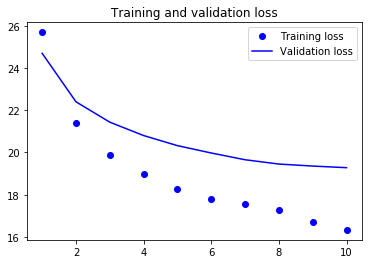

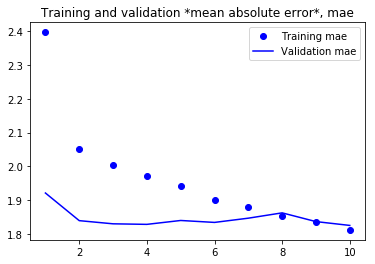

In [9]:
# plotter historikken for 'loss'
loss     = history.history['loss']
val_loss = history.history['val_loss']
mae      = history.history['mean_absolute_error']
val_mae  = history.history['val_mean_absolute_error']

epochs = range(1, NumEpochs+1)

plt.plot(epochs, loss, 'bo', label='Training loss')       # bo = "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b  = "solid blue line"
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation *mean absolute error*, mae')
plt.legend()
plt.show()

# Validering af modellen på test data
Her indlæser vi så test data, helt nye data til test

In [10]:
# vi prøver modellen på test-data
predictions = model.predict(data_test)
for i in range(1,10):
    print(('%1.4f' % predictions[i]))

3.1978
2.1201
2.6508
2.4509
3.2169
2.6635
1.7413
1.2197
2.9596


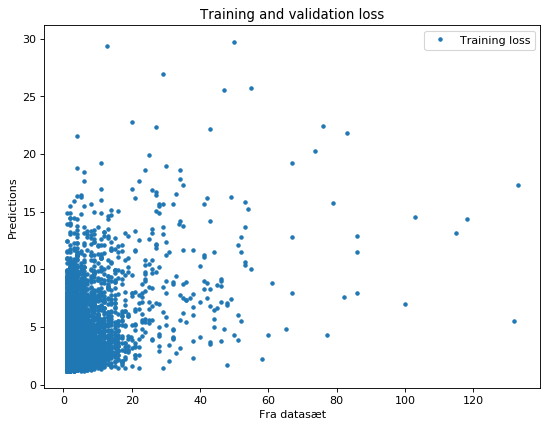

In [13]:
# plotter predictions vs 'hvad den faktisk skal være'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(NumLines_test, predictions, '.', label='Training loss')       # bo = "blue dot"
plt.xlabel('Fra datasæt')
plt.ylabel('Predictions')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [31]:
print('linje  SkalVære  Prediction  Tekst')
for i in range(1,9000):
    if NumLines_test[i] > 29:
        PrtStr = (('%4.0f' % i) + '       ' + 
                  ('%4.0f' % NumLines_test[i]) + '        ' + 
                  ('%4.1f' % predictions[i]) + '  ' + 
                  texts_test[i][:70].replace('\n', ' ').replace('\r', ''))
        print(PrtStr)

linje  SkalVære  Prediction  Tekst
  15         32         4.8  Materielfejl på Kh, holder I spor 4 med faste bremse (tiden rettet)
 979         43         8.3  Skinnebrud i FT
1538        132         5.5  Materielfejl, holder i Rungste spor 2 og har tekniske problemer.
1784         43         6.8  Svensk politi har standset trafikken i %hie pga. personer i sporet
1885         32         4.8  Signalfejl Kh giver yderligere forsinkelser
2197         35         8.7  To strømaftager revet af toget. Endnu kan vi ikke sige om der er falde
2425         32        15.6  Spærringen mellem SQ-NI, kan ikke ophæves før kl 6.
2700         34         3.2  Nedbrudt Bo
2791         86        12.9  Signalfejl KK - KH: Linieblokken mellem kk og kh er besat i begge spor
2862         38         7.9  Disponering BDK andet hoved spor er spærret i drogdetunnelen
2901         42         8.8  Signalerne i hele i RFC Ros område fra Vy til Htå faldt, flere virker 
3035         67         7.9  Person påkørsel ved